<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Tutorial 6: Training Neural Networks
November 25, 2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch            
from torch import nn, optim
from sklearn.model_selection import train_test_split

### Problem A.2 -  Gradient Descent 
Consider a single linear neuron as demapper for BPSK in AWGN. Initialize
the weight to $w = 1$, the bias to $b = 0.1$ and assume message bit $a = 1$, channel
input $x = 1$, channel output $y = 0.5$.

In [ ]:
# Data from problem 
w = 1.
b = 0.1 
y = 0.5
a = 1.

In [ ]:
# Expected results from analytical derivations
l = 0.6
gradient = - y * 1/(1+np.exp(l)) 
print(f'Value of the gradient from analytical derivation: {gradient:.4}')

Value of the gradient from analytical derivation: -0.1772


In [ ]:
# Convert data to tensors
w_t = torch.tensor([w], requires_grad=True)
b_t = torch.tensor([b])
y_t = torch.tensor([y])
a_t = torch.tensor([a])

1) Calculate the NN output by forward propagation

2) Calculate the gradient
$$\frac{d bce_{log}(a,l)}{dw}(1)$$
by back propagation.

3) Redo steps 1 and 2 using torch.tensor variables with requires grad=True
and calling the .backward() method. 
Compare the local gradients to the local gradients you calculated by hand.

In [ ]:
# Calculate L by forwards propagation
L = w_t * y_t + b_t
L.retain_grad()
print(f'Value of L from forward propagation: {L[0].detach():.2}')

Value of L from forward propagation: 0.6


In [ ]:
# Define loss function 
def bce_loss(L, a):
    return torch.log(1+torch.exp((1-2*a)*L))

In [ ]:
# Calculate loss
loss = bce_loss(L, a_t)
# Computes the gradient
loss.backward()

In [ ]:
print(f'Gradient from backpropation: {w_t.grad[0].detach() :.4}')

Gradient from backpropation: -0.1772


In [ ]:
print(f'Intermediate gradient d(loss)/dL: {L.grad[0].detach() :.4}')

Intermediate gradient d(loss)/dL: -0.3543


In [ ]:
optimizer = torch.optim.SGD([w_t], lr=0.1)

4) For learning rate $\gamma = 0.01$, calculate an update for $w$ using gradient descent.

5) Use torch.optim.SGD with $lr=0.01$ to calculate an update for $w$ and compare to the update you calculated by hand in 4.

In [ ]:
L = w_t * y_t + b_t
loss = bce_loss(L, a_t)
optimizer.zero_grad()
loss.backward()
print(f'Value of w before the step: {w_t[0].detach()}')
print(f'Value of gradient: {w_t.grad[0].detach():.4}')
optimizer.step()
print(f'Value of w after the step: {w_t[0].detach():.5}')

Value of w before the step: 1.0
Value of gradient: -0.1772
Value of w after the step: 1.0177


### Problem A.3 - Stochastic Gradient Descent 
In this problem, you train an equalizer for a dataset x.txt (the transmitted symbols) and y.txt (the received distorted signal
oversampled with 2 samples per symbol.

In [ ]:
# From tensor to numpy
def t2n(x):
    return x.reshape(-1).detach().numpy()

In [ ]:
# Downsample in time domain
def downsample_td(signal, down, time_dimension=1):
    if time_dimension == 1:
        assert len(signal.shape)==2, 'signal format [number_dimensions][signal_length] expected'
        return down * signal[:, ::down]
    if time_dimension == 0:
        assert len(signal.shape)==2, 'signal format [signal_length][number_dimensions] expected'
        return down * signal[::down, :]

In [ ]:
# Prepare the input data fot the equalizer in a diagonal form
def getchunks(x, num_taps):
    if torch.is_tensor(x):
        return _t_getchunks(x, num_taps)
    elif isinstance(x, np.ndarray):
        return _np_getchunks(x, num_taps)
    else:
        assert False, 'x must be torch.tensor or np.ndarray'

def _np_getchunks(x, num_taps):
    x = x.reshape(-1, 1)
    chunks = np.zeros((x.shape[0], num_taps))
    for j in range(num_taps):
        chunks[:, j:j+1] = np.roll(x, j - num_taps//2)
    return chunks

def _t_getchunks(x, num_taps):
    x = x.reshape(-1, 1)
    chunks = torch.zeros(x.shape[0], num_taps)
    for j in range(num_taps):
        chunks[:, j:j+1] = torch.roll(x, j - num_taps//2)
    return chunks


In [ ]:
# Define NN for nonlinear equalizer
class EQnonlinear(nn.Module):
    def __init__(self, num_taps):
        super().__init__()
        self.num_taps = num_taps
        self.lin1 = nn.Linear(num_taps, 25)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(25, 25)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(25, 25)
        self.act3 = nn.ReLU()
        self.lin4 = nn.Linear(25, 1)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        y = self.act3(self.lin3(y))
        return self.lin4(y)

##### 1) Preparation:
* Split the data set into a training set, a validation set, and a test set.

In [ ]:
# Import data
# https://drive.google.com/file/d/19lZfgoDoLuHw87TdRSB_Z7gnBundBK6g/view?usp=sharing
# https://drive.google.com/file/d/1nwZ-wyeW8t8oIHMjrAjqnh8fWNTOKUTd/view?usp=sharing

!wget -O x.txt "https://drive.google.com/uc?export=download&id=19lZfgoDoLuHw87TdRSB_Z7gnBundBK6g"
!wget -O y.txt "https://drive.google.com/uc?export=download&id=1nwZ-wyeW8t8oIHMjrAjqnh8fWNTOKUTd"

In [ ]:
# Prepare data
x = np.loadtxt('x.txt')
y = np.loadtxt('y.txt')

In [ ]:
# Train sets
x_train, x_test =  train_test_split(x, test_size=0.2, shuffle=False)
y_train, y_test =  train_test_split(y, test_size=0.2, shuffle=False)
# Validation and test sets
x_val, x_test =  train_test_split(x_test, test_size=0.5, shuffle=False)
y_val, y_test =  train_test_split(y_test, test_size=0.5, shuffle=False)

print(x_train.size, x_val.size, x_test.size)

160000 20000 20000


* Use the optimizer torch.optim.SGD with lr=0.01.

In [ ]:
# Initialize Filter
num_taps = 41
nn_filter = EQnonlinear(num_taps=num_taps)
# Learning rate
learning_rate = 1e-2
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(nn_filter.parameters(), lr=learning_rate)

* Write a training loop with an outer loop over n epochs epochs and an inner loop over batches of size batch size. Use torch.utils.data.DataLoader for sampling batches

* For each epoch, store the loss of the last batch and the loss on the validation set.

* Exit the training loop after 10s.



In [ ]:
batch_size = 1000
num_epochs = 100
dataloader = torch.utils.data.DataLoader(getchunks(y_train, num_taps).astype(np.float32),
                                         batch_size=batch_size)
labelloader = torch.utils.data.DataLoader(x_train.reshape(-1, 1).astype(np.float32),
                                          batch_size=batch_size//2)
# Prepare validation set 
y_val_t = torch.tensor(getchunks(y_val, num_taps).astype(np.float32))
x_val_t = torch.tensor(x_val.astype(np.float32)).reshape(-1, 1)

In [ ]:
import time

In [ ]:
# Set a timer
timeout = 10  #seconds
timeout_start = time.time()
# Prellocate space
loss_last_batch = []
loss_val_set = []
# Trainings loop
for j in range(num_epochs):
    for y_t, x_t in zip(dataloader, labelloader):
        x_hat = nn_filter(y_t)
        x_hat = downsample_td(x_hat, 2, 0)
        loss = loss_fn(x_hat, x_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # store loss of the last batch    
    loss_last_batch.append(loss.detach().numpy())
    # store loss of validation set 
    loss_val = loss_fn(downsample_td(nn_filter(y_val_t), 2, 0), x_val_t)
    loss_val_set.append(loss_val.detach().numpy())
    
    if j % 1 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
        
    if time.time()>(timeout_start+timeout):
        break

epoch 0: Loss = 0.0790
epoch 1: Loss = 0.0548
epoch 2: Loss = 0.0425
epoch 3: Loss = 0.0331
epoch 4: Loss = 0.0262
epoch 5: Loss = 0.0211


##### 2) 
Plot training loss and validation loss against the epoch index. Also, display in the same plot the test loss against the last epoch index.

In [ ]:
# Calculate test loss 
y_test_t = torch.tensor(getchunks(y_test, num_taps).astype(np.float32))
x_test_t = torch.tensor(x_test.astype(np.float32)).reshape(-1, 1)
loss_test = loss_fn(downsample_td(nn_filter(y_test_t), 2, 0), x_test_t).detach().numpy()

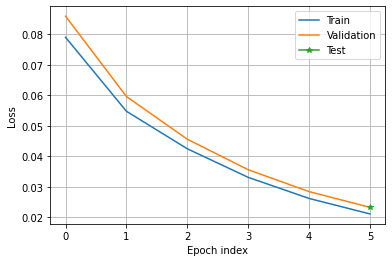

In [ ]:
# PLot
plt.plot(np.arange(len(loss_last_batch)), loss_last_batch, label="Train")
plt.plot(np.arange(len(loss_val_set)), loss_val_set, label="Validation")
plt.plot(len(loss_val_set)-1, loss_test, marker='*', label="Test")
plt.xlabel('Epoch index')
plt.ylabel('Loss')
plt.legend()
plt.grid()

##### 3) 
Search for the combination of learning rate and batch size that results in the best validation loss (after 10s of training).

In [ ]:
losses_val = []

learning_rates = [0.1, 0.05, 0.01, 0.001, 0.0001]
batch_sizes = [2, 10, 100, 1000, 10000]
for learning_rate in learning_rates:
    losses_val_lr = []
    for batch_size in batch_sizes:
        print('===========================')
        print(f'** learning_rate = {learning_rate}, batch_size={batch_size}')
        print('===========================')
        torch.manual_seed(2)
        nn_filter = EQnonlinear(num_taps=num_taps)
        # Train data
        dataloader_train = torch.utils.data.DataLoader(getchunks(y_train, num_taps).astype(np.float32),
                                                  batch_size=batch_size)
        labelloader_train = torch.utils.data.DataLoader(x_train.reshape(-1, 1).astype(np.float32),
                                                  batch_size=batch_size//2)
        
        # Define loss function and optimizer
        optimizer = optim.SGD(nn_filter.parameters(), lr=learning_rate)
        # Trainings loop
        timeout_start = time.time()
        
        for j in range(num_epochs):
            for k, (y_t, x_t) in enumerate(zip(dataloader_train, labelloader_train)):
                x_hat = nn_filter(y_t)
                x_hat = downsample_td(x_hat, 2, 0)
                loss = loss_fn(x_hat, x_t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if j % 1 == 0:
                print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
            if time.time() > timeout + timeout_start:
                break
        # Record val losses 
        loss_val = loss_fn(downsample_td(nn_filter(y_val_t), 2, 0), x_val_t)
        losses_val_lr.append(loss_val.detach().numpy())
    losses_val.append(losses_val_lr)
            

** learning_rate = 0.1, batch_size=2
epoch 0: Loss = nan
** learning_rate = 0.1, batch_size=10
epoch 0: Loss = nan
** learning_rate = 0.1, batch_size=100
epoch 0: Loss = 4.8128
epoch 1: Loss = 4.8128
epoch 2: Loss = 4.8128
** learning_rate = 0.1, batch_size=1000
epoch 0: Loss = 4.8277
epoch 1: Loss = 4.8277
epoch 2: Loss = 4.8277
epoch 3: Loss = 4.8277
epoch 4: Loss = 4.8277
epoch 5: Loss = 4.8277
** learning_rate = 0.1, batch_size=10000
epoch 0: Loss = 1.1530
epoch 1: Loss = 0.9265
epoch 2: Loss = 3.0694
epoch 3: Loss = 2.4181
epoch 4: Loss = 2.2860
** learning_rate = 0.05, batch_size=2
epoch 0: Loss = nan
** learning_rate = 0.05, batch_size=10
epoch 0: Loss = 0.0000
** learning_rate = 0.05, batch_size=100
epoch 0: Loss = 0.0030
epoch 1: Loss = 0.0016
epoch 2: Loss = 0.0013
** learning_rate = 0.05, batch_size=1000
epoch 0: Loss = 0.0318
epoch 1: Loss = 0.0186
epoch 2: Loss = 0.0109
epoch 3: Loss = 0.0116
epoch 4: Loss = 0.0049
** learning_rate = 0.05, batch_size=10000
epoch 0: Loss = 

In [ ]:
losses_val = np.array(losses_val)

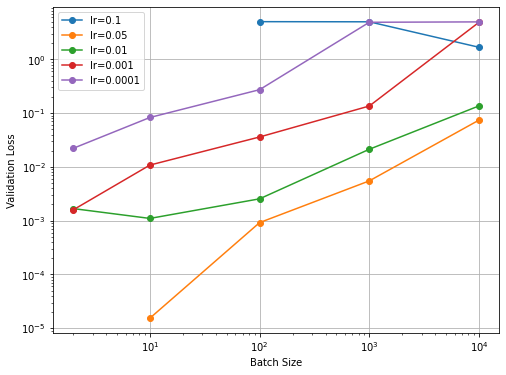

In [ ]:
plt.figure(figsize=(8,6))
for j in range(len(learning_rates)):
    loss_batch = losses_val[j,:]
    plt.loglog(batch_sizes, loss_batch, marker="o", label=f'lr={learning_rates[j]}')

plt.xlabel('Batch Size')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid()

##### 4) 
Do you achieve a better validation loss when using torch.optim.Adam as optimizer?

In [ ]:
learning_rate = 1e-2
batch_size = 1000
num_epochs = 100
dataloader = torch.utils.data.DataLoader(getchunks(y_train, num_taps).astype(np.float32),
                                         batch_size=batch_size)
labelloader = torch.utils.data.DataLoader(x_train.reshape(-1, 1).astype(np.float32),
                                          batch_size=batch_size//2)
nn_filter = EQnonlinear(num_taps=num_taps)
optimizer = optim.Adam(nn_filter.parameters(), lr=learning_rate)

In [ ]:
# Set a timer
timeout_start = time.time()
# Prellocate space
loss_last_batch_adam = []
loss_val_set_adam = []
# Trainings loop
for j in range(num_epochs):
    for y_t, x_t in zip(dataloader, labelloader):
        x_hat = nn_filter(y_t)
        x_hat = downsample_td(x_hat, 2, 0)
        loss = loss_fn(x_hat, x_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # store loss of the last batch    
    loss_last_batch_adam.append(loss.detach().numpy())
    # store loss of validation set 
    loss_val = loss_fn(downsample_td(nn_filter(y_val_t), 2, 0), x_val_t)
    loss_val_set_adam.append(loss_val.detach().numpy())
    
    if j % 1 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

    #if loss < 1e-2:
        #break
        
    if time.time()>(timeout_start+timeout):
        break

epoch 0: Loss = 0.0054
epoch 1: Loss = 0.0013
epoch 2: Loss = 0.0007
epoch 3: Loss = 0.0005
epoch 4: Loss = 0.0006


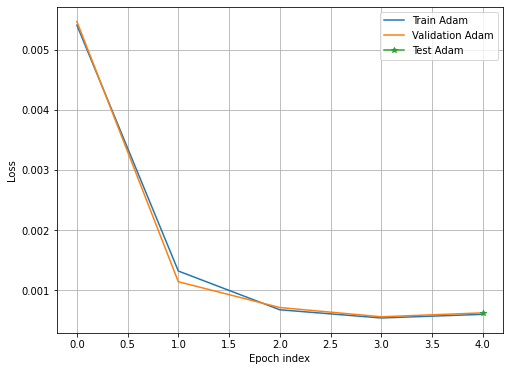

In [ ]:
# Calculate test loss 
loss_test_adam = loss_fn(downsample_td(nn_filter(y_test_t), 2, 0), x_test_t).detach().numpy()
# Plot 
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(loss_last_batch_adam)), loss_last_batch_adam, label="Train Adam")
plt.plot(np.arange(len(loss_val_set_adam)), loss_val_set_adam, label="Validation Adam")
plt.plot(len(loss_val_set_adam)-1, loss_test_adam, marker='*', label="Test Adam")

plt.xlabel('Epoch index')
plt.ylabel('Loss')
plt.legend()
plt.grid()

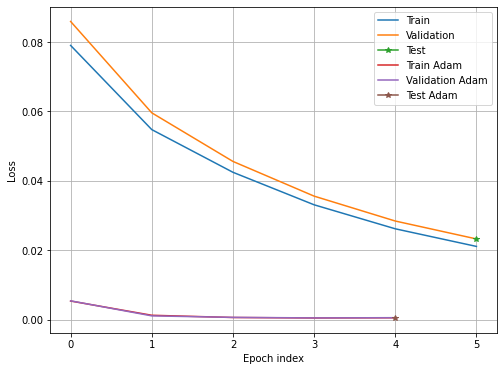

In [ ]:
# Comparative pLot
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(loss_last_batch)), loss_last_batch, label="Train")
plt.plot(np.arange(len(loss_val_set)), loss_val_set, label="Validation")
plt.plot(len(loss_val_set)-1, loss_test, marker='*', label="Test")

plt.plot(np.arange(len(loss_last_batch_adam)), loss_last_batch_adam, label="Train Adam")
plt.plot(np.arange(len(loss_val_set_adam)), loss_val_set_adam, label="Validation Adam")
plt.plot(len(loss_val_set_adam)-1, loss_test_adam, marker='*', label="Test Adam")

plt.xlabel('Epoch index')
plt.ylabel('Loss')
plt.legend()
plt.grid()